# Домашнее задание. Решение конкурса на kaggle.com

Это домашнее задание посвящено полноценному решению задачи машинного обучения.

* `train.csv`. На этом наборе данных вам необходимо создать и обучить модель. Подробное описание файла есть в ноутбуке.
* `test.csv`. В каждой строчке файла `test.csv` указаны признаки тестовых объектов. Предсказания для этого набора необходимо записать в файл submission.csv и сдать в соответствующий шаг на Stepik. Количество попыток ограничено 100 штук.

Данные: [train.csv](https://drive.google.com/file/d/1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K/view?usp=share_link), 
[test.csv](https://drive.google.com/file/d/1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r/view?usp=share_link), [submission.csv](https://drive.google.com/file/d/199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y/view?usp=share_link). 

Если ссылки на данные не работают, их можно скачать [на Kaggle](https://www.kaggle.com/competitions/advanced-dls-spring-2021/data).

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [219]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [220]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [221]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

"gdown" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"gdown" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"gdown" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [222]:
data = pd.read_csv('train (1).csv')

In [223]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [224]:
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [225]:
nan_count = pd.DataFrame(data.isna().sum())
print(nan_count)

                          0
ClientPeriod              0
MonthlySpending           0
TotalSpent                0
Sex                       0
IsSeniorCitizen           0
HasPartner                0
HasChild                  0
HasPhoneService           0
HasMultiplePhoneNumbers   0
HasInternetService        0
HasOnlineSecurityService  0
HasOnlineBackup           0
HasDeviceProtection       0
HasTechSupportAccess      0
HasOnlineTV               0
HasMovieSubscription      0
HasContractPhone          0
IsBillingPaperless        0
PaymentMethod             0
Churn                     0


In [226]:
data = data.fillna(0)
(data.isna().sum() == 0).all()

True

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

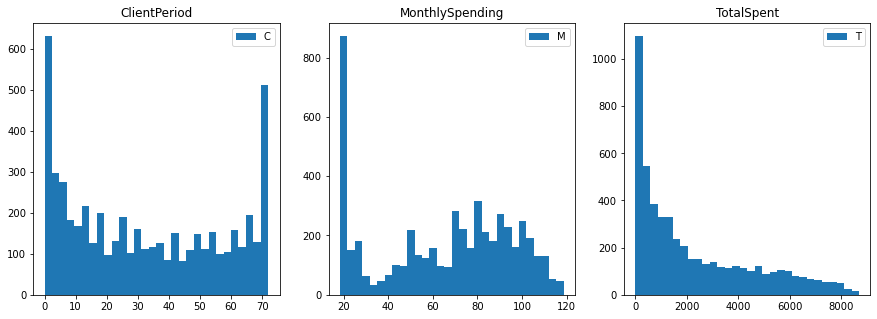

In [227]:
data['TotalSpent'] = data['TotalSpent'].replace(to_replace='', value='0.0')
data['TotalSpent'] = data['TotalSpent'].replace(to_replace=' ', value='0.0')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for index, feat in enumerate(num_cols):
    ax[index].hist(data[feat], bins=30)
    ax[index].set_title(feat)
    ax[index].legend(feat)

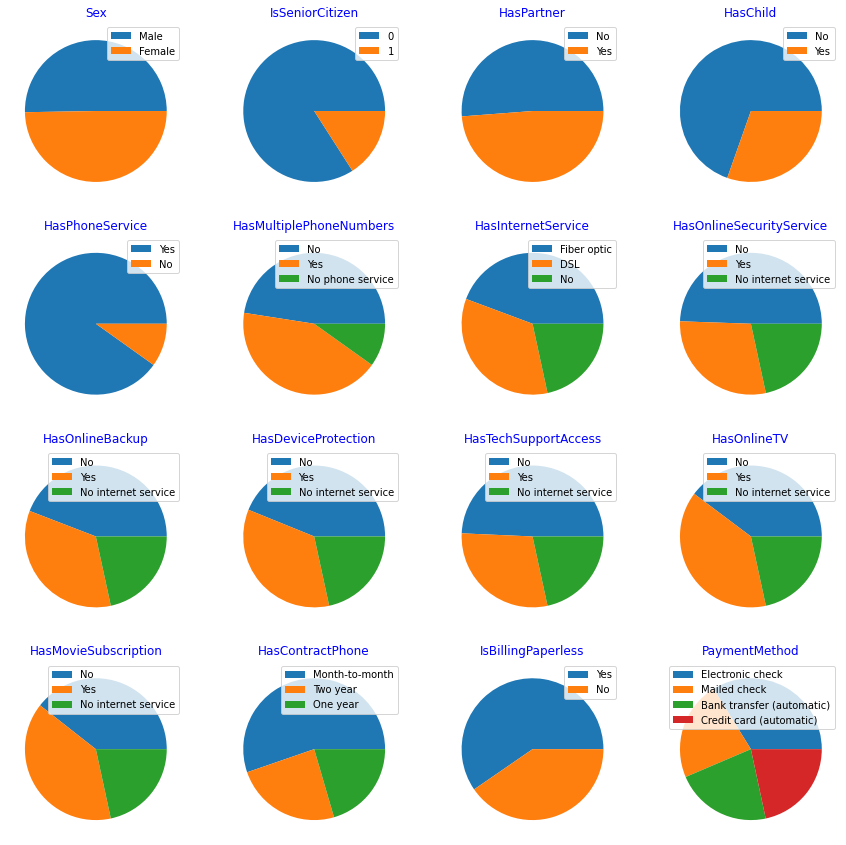

In [228]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for index, feat in enumerate(cat_cols):
    ax[index // 4][index % 4].pie(data[feat].value_counts())
    ax[index // 4][index % 4].set_title(feat, color='blue')
    ax[index // 4][index % 4].legend(data[feat].value_counts().index)

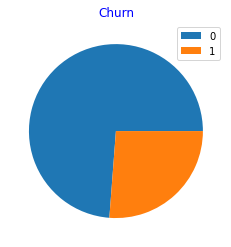

In [229]:
plt.pie(data[target_col].value_counts())
plt.title(target_col, color='blue')
plt.legend(data[target_col].value_counts().index);
# классы сбалансированы

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [230]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [169]:
data1 = pd.get_dummies(d
                       ata, columns=cat_cols, drop_first=True)
X = data1.drop(['Churn'], axis=1)
y = data['Churn']

In [231]:
est = make_pipeline(StandardScaler(), LogisticRegression())
clf = GridSearchCV(estimator=est, param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]}, scoring='roc_auc')
clf.fit(X, y)
best_clf = clf.best_estimator_
clf.best_score_

0.8451222820603009

In [232]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=100))])

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Лучшее качество удалось получить с параметром С = 100. Лучшее качество : 0.845.

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [288]:
import catboost
from sklearn.metrics import roc_auc_score, roc_curve
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Churn'), y, test_size=0.3)

In [281]:
boosting_model = catboost.CatBoostClassifier(silent=True,
                                    cat_features=cat_cols,
                                    eval_metric='AUC')
boosting_model.grid_search({'learning_rate': np.linspace(0, 0.2, 15), 'n_estimators': [100, 150, 200]}, 
                                  X_train, 
                                  y_train, 
                                  plot=True, 
                                  refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8396607504
bestIteration = 89

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8396608	best: 0.8396608 (0)	total: 6.59s	remaining: 4m 50s

bestTest = 0.8407090442
bestIteration = 86

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8407090	best: 0.8407090 (1)	total: 12.3s	remaining: 4m 25s

bestTest = 0.8392721588
bestIteration = 97

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8392722	best: 0.8407090 (1)	total: 18.3s	remaining: 4m 15s

bestTest = 0.8385491975
bestIteration = 94

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8385492	best: 0.8407090 (1)	total: 23.6s	remaining: 4m 2s

best

{'params': {'iterations': 200, 'learning_rate': 0.17142857142857143},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,


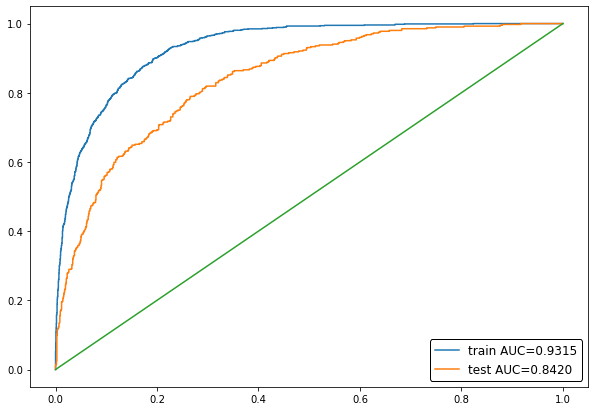

In [282]:
y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Выпишите, какое лучшее качество и с какими параметрами вам удалось получить

Лучшее качество удалось получить с параметром 'iterations': 200, 'learning_rate': 0.17142857142857143. Лучшее качество : 0.8420.

# Предсказания

In [286]:
best_model = catboost.CatBoostClassifier(iterations = 200, learning_rate = 0.17142857142857143, silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC')
best_model.fit(X_train, y_train)

In [289]:
print(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

0.9070917923195689


In [292]:
X_test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]

submission.to_csv('./my_submission.csv', index=False)

Лучшее решение отправьте в Stepik.

In [291]:
submission['Churn'] 

0       0.018356
1       0.743358
2       0.679598
3       0.010878
4       0.001302
          ...   
1756    0.206226
1757    0.007467
1758    0.935936
1759    0.707232
1760    0.003056
Name: Churn, Length: 1761, dtype: float64